# <center>Realistic fractional quantum Hall energy gaps in graphene via Monte Carlo simulations</center>

<center>Paul Fischer and Michael R. Peterson</center>
<center>
    <i>Department of Physics & Astronomy, California State University Long Beach, Long Beach, California 90840,     USA</i>
</center>
<center>(Dated: June 28, 2022)</center>

<center>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We fit perturbative, Landau level mixing-incorporated, two-body Haldane pseudopotential corrections of fractional quantum Hall states to data in the lowest Landau level. We use these corrections to develop equations that approximate the fitting parameters that map a real-space effective potential to the spherical geometry. We use this approximated effective potential to calculate Landau level mixing-incorporated energy gaps for fractional quantum Hall states of graphene via a variational Monte Carlo algorithm and benchmark the results against exact diagonalization.
</center>

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display, Latex
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from typing import Tuple, List
from scipy.optimize import curve_fit, root
import scipy.integrate as integrate
from scipy.special import eval_legendre
from sympy import N, symbols, solve, exp, LambertW, sqrt, simplify, init_printing
from sympy.physics.wigner import wigner_3j, wigner_6j
from statistics import fmean, stdev

plt.style.use('classic')
mpl.rcParams['font.size'] = 15
mpl.rcParams['axes.grid'] = True
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['legend.numpoints'] = 1
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12) 
init_printing(use_unicode=True)

print_plots_to_pdf = False
plots_file_path = 'images/'

<a id='sec1'></a>
## <center>I. INTRODUCTION</center>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The fractional quantum Hall effect (FQHE) arises in quasi-two-dimensional electron systems at low temperatures when a strong magnetic field $B$ is perpendicularly applied such that the electron filling factor $\nu$ is a rational fraction. When mapping the problem onto the Haldane sphere, $B$ originates from a magnetic monopole of strength $Q$ at its center. We can then refer to the z-component of angular momentum $m$ in terms of the relative angular momentum in the spherical geometry, $2l-m$, where $l=|Q|+|n|$ is the single-particle angular momentum and $n$ is the Landau level (LL) index. Jain *et al*. developed a Markov chain Monte Carlo (MC) method via the Metropolis-Hastings algorithm (MHA) for calculating  ground state energies and gaps to excitations of electrons in FQH states. This allowed for the study of larger systems than the previous method of exact diagonalization (ED) of the Laughlin wavefunction via building Slater determinants<sup>[1](#Bibliography)</sup>.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Park *et al*. published an effective potential for performing MC calculations in the lowest LL which contained parameters that could be fit to simulate electrons in a higher LL<sup>[2](#Bibliography)</sup>. In their PhD thesis, Wooten established a method for mapping such a real-space effective potential to a Haldane pseudopotential (PP) on the Haldane sphere, $V^{(n)}_{2l-m}$<sup>[3](#Bibliography)</sup>. Landau level mixing (LLM) can occur when electron-electron Coulomb interactions in a partially filled LL push electrons into higher LLs or holes into lower LLs; and since graphene has a linear electron dispersion, the magnetic field dependency from the LLM parameter $\kappa$ vanishes, so LLM cannot be suppressed by a sufficiently strong magnetic field (in graphene, $0.5\lesssim\kappa\leq2.2$ depending on the substrate). Therefore, Arciniaga *et al*. calculated two-body PP energies for FQH states of graphene in the spherical geometry that incorporated LLM effects perturbatively, $V_{2 l-m, 2 \text { body }}^{(n)}(\kappa)=V_{2 l-m}^{(n)}+\kappa \delta V_{2 l-m}^{(n)}$, where $\delta V_{2 l-m}^{(n)}$ is the LLM-incorporated PP correction. A more general model for FQHE energy states in materials like graphene might provide clues for ways to experimentally demonstrate fractional statistics and non-Abelian quasiparticles which could be the key step in building a topologically protected quantum computer.<sup>[4](#Bibliography)</sup>. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Composite fermion (CF) theory treats a system of FQH electrons at lowest Landau level filling factor $\nu=\frac{n}{2pn\pm1}$, where $n,p\in\mathbb{N}$, as a system of non-interacting integer quantum Hall electrons attached to 2p quantum vortices in the reduced magnetic field $B^*=B-2p\rho \phi_0$, where they occupy $\nu^*=n$ Landau-like $\Lambda$ levels, $\rho$ is the two-dimesional density, and $\phi_0=hc/e$ is the flux quanta<sup>[5](#Bibliography)</sup>. Park $\textit{et al.}$ investigated the mysterious even-denominator FQH state at $\nu=5/2$, where the CF filling factor of the first-excited LL is $\nu^*=1/2$ and there is no explicit form of the wavefunction. They devised the following effective interaction in the lowest LL which produced the same PPs as the Coulomb interaction in the first-excited LL: $V_{eff}(r)=\left(\frac{1}{r}+a_1e^{-\alpha_1r^2}+a_2r^2e^{-\alpha_2r^2}\right)\left[\frac{e^2}{\epsilon l_B}\right]$, where the distance $r$ is in measured in units of effective magnetic length $l_{B^*}=(\hbar c/eB^*)^{1/2}$, the fitting parameters $\{a_1,a_2,\alpha_1,\alpha_2\}$ are calculated by fitting the first four significant PPs exactly, $\epsilon$ is the dielectric constant of the background material, and $l_{B}$ is the magnetic length at actual electron filling factor $\nu$. The first four significant PPs are those for which $m\in\{1,3,5,7\}$ - they are odd because the many-body wavefunction has to be fully anti-symmetric under particle exchange for fermions and since in the planar geometry $m$ is directly proportional to $r$ in the potential $V(r)$, the first four sample the strongest Coulomb interactions<sup>[2](#Bibliography)</sup>. Since many real-space interactions can produce the same PPs, Lee $\textit{et al.}$ used the following form which they found more convenient: $V^{\mathrm{CF}}(r)=\left(\sum_{j} c_{j} r^{2 j} e^{-r^{2}}+\frac{(2 n+1)^{-5 / 2}}{r}\right)\left[\frac{e^{2}}{\epsilon l_B}\right]$, where the first few parameters $c_j$ were produced by fitting the first five to six significant PPs exactly<sup>[6](#Bibliography)</sup>. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We will be measuring energy gaps via the CF-exciton $\Delta$ dispersion as a function of $kl=L/\sqrt{Q}$, where $L$ is the total angular momentum. CF-excitons are quasiparticle and quasihole pairs created by the excitation of a CF to an unoccupied $\Lambda$ level. They are calculated as the difference between the $L=0$ ground state energy and the lowest energy at $L\leq N$. The roton $\Delta_r$ is the minimum of the exciton dispersion and can be measured experimentally via inelastic Raman scattering. The transport gap $\Delta_t$ is the energy required to create a quasiparticle and quasihole pair separated far enough to contribute to transport, calculated as the difference between the $L=0$ ground state energy and the lowest energy at $L=N$ since the CF-excitons converge to a constant value for large $L$. They can be measured experimentally via longitudinal resistance as a function of temperature<sup>[5](#Bibliography)</sup>. Jain *et al.* calculated that these energy gaps in the lowest LL for the Coulomb potential with $\nu=1/3$ as a function of $kl$ converge to $0.106(3)$ [$e^2/\epsilon l_B$]<sup>[1](#Bibliography)</sup>.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;This notebook is organized as follows: in Sec. [II](#sec2) we fit two-body, perturbative, LLM-incorporated PP correction data in the lowest LL, in Sec. [III](#sec3) we map the effective potential to the Haldane sphere and incorporate LLM, in Sec. [IV](#sec4) we fit the effective potential fitting parameters, in Sec. [V](#sec5) we analyze the approximated LLM-incorporated PPs, in Sec. [VI](#sec6) we calculate the CF-exciton dispersion for $\nu=1/3$, in Sec. [VII](#sec7) we benchmark the CF-exciton dispersion against exact diagonalization, in Sec. [VIII](#sec8) we analyze our sources of error, and, finally in Sec. [IX](#sec9) we conclude. For completeness, we discuss interesting behavior and other necessary calculations in appendices [A](#appA) and [B](#appB).

<a id='sec2'></a>
## <center>II. FITTING THE TWO-BODY, LANDAU LEVEL MIXING-INCORPORATED HALDANE PSEUDOPOTENTIAL PERTURBATIVE CORRECTIONS IN THE LOWEST LANDAU LEVEL</center>

In the cell below are the two-body LLM-incorporated PP corrections in the lowest LL given in Table III of Arciniaga, where $\delta\bar{V}^{(0)}_{m,2body}$ are the corrections in the thermodynamic limit, or planar geometry<sup>[4](#Bibliography)</sup>.

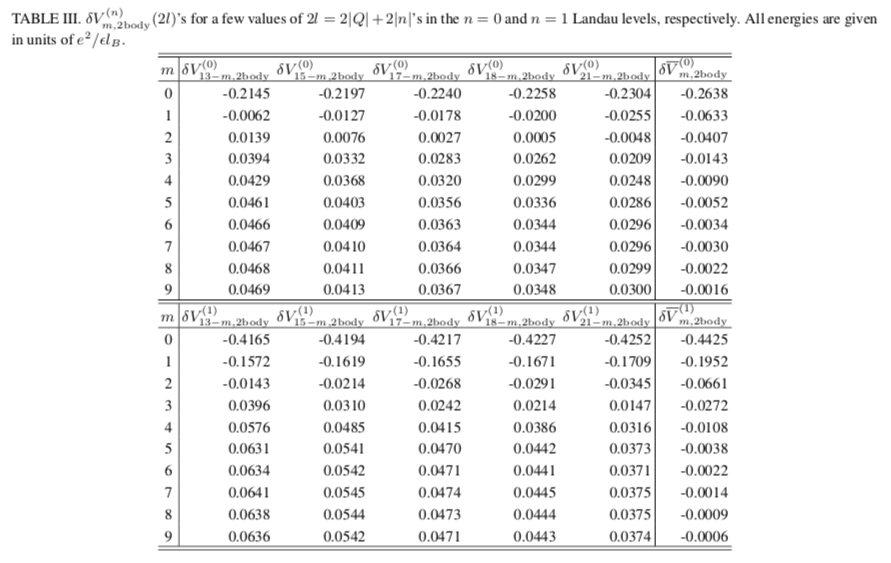

We want to calculate the fitting parameters for benchmarking $6\leq N\leq10$ electrons at filling factor $\nu=1/3$ in the lowest LL with LLM parameters $\kappa\in\{0.0,0.1,0.2\}$. From the total flux on the sphere for Laughlin states at this filing factor, $2l=3(N-1)$, we have $Q=\frac{3}{2}(N-1)$, so we will need the fitting parameters for $N=10\rightarrow Q=13.5$<sup>[4](#Bibliography)</sup>. This corresponds to $\delta V^{(n)}_{2l-m,2body}=\delta V^{(0)}_{27-m,2body}$, which is not included the table above. We will therefore extrapolate from the data an approximate result via a linear fit. Let us generate a DataFrame of the table above manually, where we are only interested in the odd $m$ values (see Sec. [I](#sec1)). (NOTE: The DataFrame below uses the column labels <code>dV(Q=*)</code> since in this notebook we only work with two-body PPs in the lowest LL.)

In [2]:
delta_data = [[1, -0.0062, -0.0127, -0.0178, -0.0200, -0.0255, -0.0633], 
        [3, 0.0394, 0.0332, 0.0283, 0.0262, 0.0209, -0.0143],
        [5, 0.0461, 0.0403, 0.0356, 0.0336, 0.0286, -0.0052],
        [7, 0.0467, 0.0410, 0.0364, 0.0344, 0.0296, -0.0030],
        [9, 0.0469, 0.0413, 0.0367, 0.0348, 0.0300, -0.0016],] 
  
dfDeltas = pd.DataFrame(delta_data, columns = ['m', 'dV(Q=6.5)', 'dV(Q=7.5)', 
                                   'dV(Q=8.5)', 'dV(Q=9.5)', 'dV(Q=10.5)', 'dV(Q->inf)']) 
   
dfDeltas.head()

,m,dV(Q=6.5),dV(Q=7.5),dV(Q=8.5),dV(Q=9.5),dV(Q=10.5),dV(Q->inf)
0,1,-0.0062,-0.0127,-0.0178,-0.0200,-0.0255,-0.0633
1,3,0.0394,0.0332,0.0283,0.0262,0.0209,-0.0143
2,5,0.0461,0.0403,0.0356,0.0336,0.0286,-0.0052
3,7,0.0467,0.0410,0.0364,0.0344,0.0296,-0.0030
4,9,0.0469,0.0413,0.0367,0.0348,0.0300,-0.0016


We can perform a linear fit to the data as a function of $1/Q$ for each value of $m$.

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

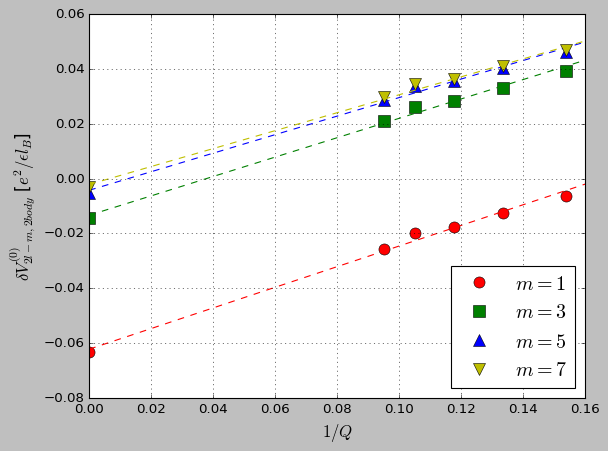

In [3]:
qInv = [1/6.5, 1/7.5, 1/8.5, 1/9.5, 1/10.5, 0]
deltaM1 = dfDeltas.iloc[0, 1:].tolist()
deltaM3 = dfDeltas.iloc[1, 1:].tolist()
deltaM5 = dfDeltas.iloc[2, 1:].tolist()
deltaM7 = dfDeltas.iloc[3, 1:].tolist()

# linear fit
prmsM1 = np.polyfit(qInv, deltaM1, 1)
fitM1 = np.poly1d(prmsM1)
# all deltas in the thermodynamic limit are negative
display( Latex(f'$m=1\\rightarrow\delta V^{{(0)}}_{{2l-1,2body}}={prmsM1[0]}/Q-{abs(prmsM1[1])}$') )

prmsM3 = np.polyfit(qInv, deltaM3, 1)
fitM3 = np.poly1d(prmsM3)
display( Latex(f'$m=3\\rightarrow\delta V^{{(0)}}_{{2l-3,2body}}={prmsM3[0]}/Q-{abs(prmsM1[1])}$') )

prmsM5 = np.polyfit(qInv, deltaM5, 1)
fitM5 = np.poly1d(prmsM5)
display( Latex(f'$m=5\\rightarrow\delta V^{{(0)}}_{{2l-5,2body}}={prmsM5[0]}/Q-{abs(prmsM1[1])}$') )

prmsM7 = np.polyfit(qInv, deltaM7, 1)
fitM7 = np.poly1d(prmsM7)
display( Latex(f'$m=7\\rightarrow\delta V^{{(0)}}_{{2l-7,2body}}={prmsM7[0]}/Q-{abs(prmsM1[1])}$') )

# plot
x = np.linspace(0, 0.16, 16)

plt.plot(qInv, deltaM1, 'ro', label='$m=1$')
plt.plot(x, fitM1(x), 'r--')

plt.plot(qInv, deltaM3, 'gs', label='$m=3$')
plt.plot(x, fitM3(x), 'g--')

plt.plot(qInv, deltaM5, 'b^', label='$m=5$')
plt.plot(x, fitM5(x), 'b--')

plt.plot(qInv, deltaM7, 'yv', label='$m=7$')
plt.plot(x, fitM7(x), 'y--')

plt.xlabel('$1/Q$')
plt.ylabel('$\delta V^{(0)}_{2l-m,2body}$ [$e^2/\epsilon l_B$]')
plt.legend(loc='lower right')

if print_plots_to_pdf:
    plt.savefig(plots_file_path + 'delta_vs_1_over_q.pdf', format="pdf", bbox_inches="tight")
    
plt.show()

<a id='sec3'></a>
## <center><span style="text-transform:uppercase;">III. Mapping a real-space effective potential to the spherical geometry and incorporating Landau level mixing</span></center>

The Lee potential (see Sec. [I](#sec1)) required fitting the parameters $c_j$ for polynomial degrees higher than 2 which, when we adapted it to a continuous general formula/number of parameters as a function of $\kappa$ and $Q$, created local minima that the MHA got stuck in to produce energies with errors on the order of up to $10^6\%$. With the goal of minimizing the computational complexity of calculating the fitting parameters, we tried many combinations of elementary functions and numbers of parameters, but eventually chose the following modified Park potential since it produced the most accurate energies after being run through the the MC code in the lowest LL for $\nu=1/3$, $6\leq N\leq10$, and $\kappa\in\{0.0,0.1,0.2\}$: $V_{eff}(r)=\left(\frac{1}{r}+b_1e^{-\beta_1r}+b_2r^2e^{-\beta_2r}\right)\left[\frac{e^2}{\epsilon l_B}\right]$, where the distance $r$ is measured in units of $l_B$. The degree of the polynomial in the exponential was reduced in an attempt to push the effects of LLM towards the larger $r$ values where the MC code was sampling since CF theory generally does a good job of keeping the quasiparticles spaced far apart (we will discuss this point later). Let us define our modified Park potential as a function below.

In [1]:
def vEff(r: float, prms: Tuple[float]) -> float:
    """Return the two-body real-space effective potential."""
    
    b1, b2, beta1, beta2 = prms
    
    return 1/r + b1*np.exp(-beta1*r) + b2*r**2*np.exp(-beta2*r)

NameError: name 'Tuple' is not defined

Let us define as a function the Wooten formula for mapping a two-body real-space effective potential to a PP in the spherical geometry in the lowest Landau level, $V^{(0)}_{Q,m}(L)=\frac{(-1)^{2Q+L}(2Q+1)^2}{\sqrt{Q}}\sum_{k=0}^{2Q}V_k\begin{Bmatrix}L&Q&Q\\k&Q&Q\end{Bmatrix}\begin{pmatrix}Q&k&Q\\-Q&0&Q\end{pmatrix}^2$, where $L=2l-m$ is the relative angular momentum in the spherical geometry, $V_k=\frac{2k+1}{2}\int_{-1}^1V_{eff}(\sqrt{2(1-x)})P_k(x)dx$, and $P_k(x)$ is the Legendre polynomial<sup>[3](#Bibliography)</sup>.

In [5]:
def vK(k: int, prms: Tuple[float]) -> float:
    """Return the V_k term of Wooten's formula for mapping a two-body, real-space effective potential
    to a Haldane pseudopotential."""
    
    coeff = (2*k+1)/2
    integ = integrate.quad(lambda x: vEff(np.sqrt(2*(1-x)), prms)*eval_legendre(k, x), -1, 1)
    
    return coeff*integ[0]

def wootenPP(qL: Tuple[float], prms: Tuple[float]) -> float:
    """Return the value of the effective potential that has been mapped
    to a Haldane pseudopotential via the Wooten formula."""
    
    q, l = qL
    
    coeff = (-1)**(2*q+l) * (2*q+1)**2/np.sqrt(q)
    
    # save terms in the sum as a list to be summed over
    sumTerms = []
    for k in range(int(2*q+1)):
        # in the lowest Landau level l = Q
        sumTerms.append(
               vK(k, prms)*N(wigner_6j(l, q, q, k, q, q))*N(wigner_3j(q, k, q, -q, 0, q))**2)
    
    return coeff*sum(sumTerms)

Let us define a function that can be used to numerically solve for the parameters that fit the effective potential to the LLM-incorporated PP data for the first four odd $m$ values.

In [6]:
def findRootWootenPP(prms: Tuple[float], args: List[float]) -> List[float]:
    """Return the difference between the Coulomb and Landau level mixing-incorporated Haldane pseudopotentials
    for the first nPrms odd m values so a root finding method can solve for the fitting parameters."""
    
    # need as many equations as there are parameters
    nPrms = len(prms)
    
    # args input is [q, kappa, deltas[0:nPrms]]
    q, kappa, deltas = args[0], args[1], args[2:nPrms+2]

    res = []
    for i in range(nPrms):
        
        # m odd
        m = 2*i+1
        
        # L = 2Q-m in the lowest LL
        qL = (q, 2*q-m)
        
        # Coulomb parameters
        prms0 = ()
        for j in range(nPrms):
            prms0 = prms0 + (0.0,)
        
        # V_eff = V_Coulomb + kdV
        llmPP = wootenPP(qL, prms0) + kappa * deltas[i]
        
        res.append(wootenPP(qL, prms) - llmPP)
    
    return res

Let us define a function that will return the fitting parameters via a root-finding modified Powell method for the effective potential for a given $Q$ and $\kappa$.

In [7]:
def fittingPrms(args: List[float], prms0: Tuple[float]) -> Tuple[float]:
    """Return the parameters that fit the effective potential to the Landau level mixing-incorporated Haldane
    pseudopotential data."""
    
    # need as many equations as there are parameters
    nPrms = len(prms0)
    
    # args input is [q, kappa, deltas[0:nPrms]]
    q, kappa, deltas = args[0], args[1], args[2:nPrms+2]

    # find roots
    sol = root(findRootWootenPP, prms0, args=(args), method='hybr')
    
    return tuple(sol.x)

Let us define a function that returns as a DataFrame the effective potentials as a function of $L$ which will be used  for benchmarking the MC code against the results from ED.

In [1]:
def vqlDF(q: float, kappa: float, prms: Tuple[float]) -> pd.DataFrame:
    """Return a DataFrame containing the fitted Landau level mixing-incorporated Haldane pseudopotentials as a 
    function of the single-particle relative angular momentum in the spherical geometry L."""

    # need as many equations as there are parameters
    nPrms = len(prms)
    
    # m can be any odd value up to 2Q in the lowest LL
    mArray = list( range(1, int(2*q + 1), 2) )
    
    # generate PPs from fitted Park parameters
    data = []
    for m in mArray:
        # L = 2Q - m in the lowest LL
        qL = (q, 2*q - m)
        data.append([qL[1], wootenPP(qL, prms)])
    
    # put in order of increasing L
    data.reverse()
    
    return pd.DataFrame(data, columns = ['L', 'V_Q(L)'])

NameError: name 'Tuple' is not defined

We will use this function to generate an example DataFrame below with the fitted PP values in the lowest LL for $\nu=1/3$, $N=6$, and $\kappa=0.0$, where the $L\in\{0.0,2.0,4.0,6.0\}$ values will be approximated since the first four odd $m$ values (last four even $L$ values) were fit exactly.

In [9]:
n = 6
kappa = 0.1

# generate initial parameters (0.1, 0.2, 0.3, ...)
nPrms = 4
prms0 = ()
for i in range(nPrms):
    prms0 = prms0 + ((i+1.0)/10.0,)

# Laughlin state with nu = 1/3
q = (3*n - 3) / 2

args = [q, kappa]
for i in range(nPrms):
    if i == 0:
        args.append(fitM1(1/q))
    if i == 1:
        args.append(fitM3(1/q))
    if i == 2:
        args.append(fitM5(1/q))
    if i == 3:
        args.append(fitM7(1/q))
    if i > 3:
        args.append(fitM9(1/q))

prms = fittingPrms(args, prms0)

print('prms =', prms)

prms = (-0.3081699287592883, 0.04776248286228409, 4.476701208493405, 1.4553101470325063)


In [10]:
dfPP = vqlDF(q, kappa, prms)

dfPP

,L,V_Q(L)
0,0.0,0.192341675305467
1,2.0,0.194694914129701
2,4.0,0.200533590680915
3,6.0,0.210853711516977
4,8.0,0.227852918264763
5,10.0,0.256686687971981
6,12.0,0.312583334986476
7,14.0,0.476895581131777


<a id='sec4'></a>
## <center><span style="text-transform:uppercase;">IV. Fitting to the effective potential fitting parameters</span></center>

Let us use all of the intended $N$ (approaching the thermodynamic limit) and $\kappa$ values in the lowest LL for $\nu=1/3$ to generate a DataFrame of the parameters $\{b_1,b_2,\beta_1,\beta_2\}$ that fit the effective potential to the first four odd $m$-valued LLM-incorporated PPs exactly so we can fit those parameters to functions of $\kappa$ and/or $Q$. The following cell took approximately 6 hours to run so it has been converted to Markdown for reference and the data is stored in/read in from the local <code>data</code> folder.

```python
nList = [4, 5, 6, 7, 8, 9, 10, 11, 13, 16, 20, 25, 30, 40, 50]
kappaList = [0.0, 0.1, 0.2, 0.5, 0.8, 0.9, 2.2]

# nll = 1 for nu = 1/3, nll = 2 for nu = 2/5, nll = 3 for nu = 3/7, ...
nll = 1
nu = nll/(2*nll + 1)

# Q = 4.5, kappa = 0.1 parameters
prms = (-0.16003452474870744, 0.06323270278261377, 3.0482676778673947, 1.4193852974810786)

# create DataFrame
data = []
for n in nList:
    q = (n/nu - (nll+2))/2
    
    for kappa in kappaList:
        args = [q, kappa, fitM1(1/q), fitM3(1/q), fitM5(1/q), fitM7(1/q)]
        
        if kappa == 0.0:
            data.append([q, kappa, 0.0, 0.0, 0.0, 0.0])
        
        # use parameters from last kappa!=0.0 iteration as initial parameters for fit
        else:
            prms = fittingPrms(args, prms)
            data.append([q, kappa, prms[0], prms[1], prms[2], prms[3]])
        
dfPrms = pd.DataFrame(data, columns = ['Q', 'kappa', 'b1', 'b2', 'beta1', 'beta2'])
dfPrms.to_csv(r'data/parameterDataNu13.csv', index=False)
```

In [11]:
dfPrms = pd.read_csv(r'data/parameterDataNu13.csv')

dfPrms.head()

,Q,kappa,b1,b2,beta1,beta2
0,4.5,0.0,0.000000,0.000000,0.000000,0.000000
1,4.5,0.1,-0.160035,0.063233,3.048268,1.419385
2,4.5,0.2,-0.320069,0.126465,3.048268,1.419385
3,4.5,0.5,-0.800173,0.316164,3.048268,1.419385
4,4.5,0.8,-1.280276,0.505862,3.048268,1.419385


Let us define a function to fit parameters $c_i$ to the DataFrame above such that the parameters $b_i$ approximately follow the relation $b_i(Q,\kappa)=(c_1Q^{c_2}+c_3)\kappa$. (NOTE: The form of this function was chosen via trial and error.)

In [12]:
def b12Func(qKappa: Tuple[float], c1: float, c2: float, c3: float) -> float:
    """Return the value of the Landau Level mixing-incorporated Haldane pseudopotential parameter function 
    b_i(Q, kappa)."""
    
    q, kappa = qKappa
    
    return (c1*q**c2 + c3)*kappa

In [13]:
def b_fun_prms(dfPrms: pd.DataFrame, prms0: List[float], b1: bool=False, b2: bool=False) -> np.ndarray:
    """Return the parameters c_i for the Landau Level mixing-incorporated Haldane pseudopotential parameter function 
    b_i(Q, kappa)."""
    
    try:
        if b1 and not b2:
            col = 'b1'
        elif b2 and not b1:
            col = 'b2'
        else:
            raise ValueError

        # make DataFrame of values for Q>6 since the fit will be more accurate and we are interested in the therm lim
        dfTemp = dfPrms.query('(Q > 6.0) & (kappa > 0.0)')
        dfTemp.reset_index(drop=True, inplace=True)

        x = ( dfTemp['Q'].to_list(), dfTemp['kappa'].to_list() )
        y = dfTemp[col].to_list()

        prms, pcov = curve_fit(b12Func, x, y, prms0)
        
        return prms

    except ValueError:
        return 'ValueError: please input \'b1=True\' xor \'b2=True\'.'

In [14]:
b1_prms0 = [-1.14607611, 0.45221604, -0.27648712]
b2_prms0 = [1.84723791e-04, 2.27427673e+00, 4.84262682e-01]

b1_prms = b_fun_prms(dfPrms, b1_prms0, b1=True)
b2_prms = b_fun_prms(dfPrms, b2_prms0, b2=True)

display( Latex(f'$b_1(Q,\kappa)=({b1_prms[0]}Q^{{{b1_prms[1]}}}{b1_prms[2]})\kappa$') )
display( Latex(f'$b_2(Q,\kappa)=({b2_prms[0]}Q^{{{b2_prms[1]}}}+{b2_prms[2]})\kappa$') )

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

We can qualitatively view the accuracy of these fits below.

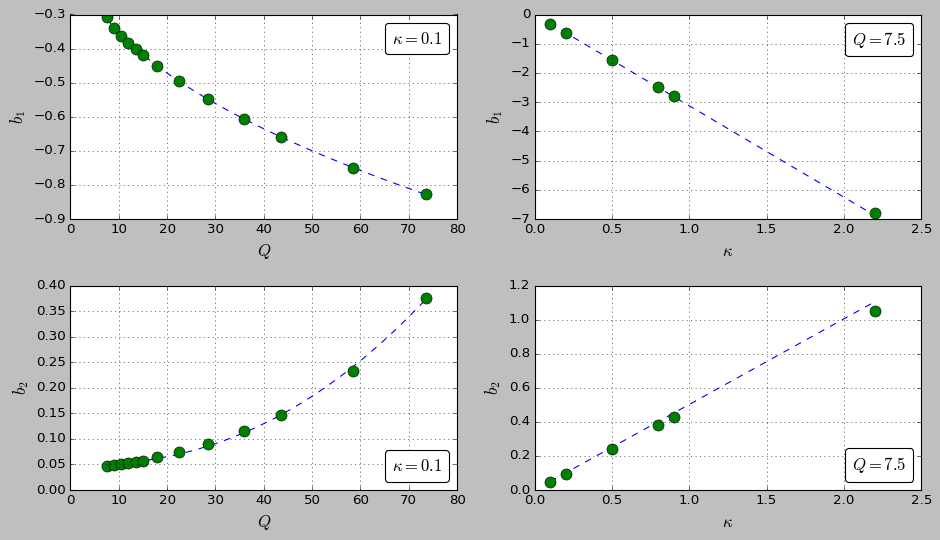

In [15]:
fig, axs = plt.subplots( 2, 2, figsize=(12, 7) )

# b1 vs. Q for kappa = 0.1
x_exact = dfPrms.query('(kappa == 0.1) & (Q > 6.0)')['Q'].to_list()
y_exact = dfPrms.query('(kappa == 0.1) & (Q > 6.0)')['b1'].to_list()
x_fit = np.linspace(7.5, 73.5, num=150)
y_fit = b12Func( (x_fit, 0.1), b1_prms[0], b1_prms[1], b1_prms[2] )
axs[0, 0].plot(x_fit, y_fit, '--')
axs[0, 0].plot(x_exact, y_exact, 'o')
axs[0, 0].set_xlabel(r'$Q$')
axs[0, 0].set_ylabel(r'$b_1$')
at00 = AnchoredText(r'$\kappa=0.1$', prop=dict(size=15), frameon=True, loc='upper right')
at00.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axs[0, 0].add_artist(at00)

# b1 vs. kappa for Q = 7.5
x_exact = dfPrms.query('(kappa > 0.0) & (Q == 7.5)')['kappa'].to_list()
y_exact = dfPrms.query('(kappa > 0.0) & (Q == 7.5)')['b1'].to_list()
x_fit = np.linspace(0.1, 2.2, num=100)
y_fit = b12Func( (7.5, x_fit), b1_prms[0], b1_prms[1], b1_prms[2] )
axs[0, 1].plot(x_fit, y_fit, '--')
axs[0, 1].plot(x_exact, y_exact, 'o')
axs[0, 1].set_xlabel(r'$\kappa$')
axs[0, 1].set_ylabel(r'$b_1$')
at01 = AnchoredText(r'$Q=7.5$', prop=dict(size=15), frameon=True, loc='upper right')
at01.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axs[0, 1].add_artist(at01)

# b2 vs. Q for kappa = 0.1
x_exact = dfPrms.query('(kappa == 0.1) & (Q > 6.0)')['Q'].to_list()
y_exact = dfPrms.query('(kappa == 0.1) & (Q > 6.0)')['b2'].to_list()
x_fit = np.linspace(7.5, 73.5, num=150)
y_fit = b12Func( (x_fit, 0.1), b2_prms[0], b2_prms[1], b2_prms[2] )
axs[1, 0].plot(x_fit, y_fit, '--')
axs[1, 0].plot(x_exact, y_exact, 'o')
axs[1, 0].set_xlabel(r'$Q$')
axs[1, 0].set_ylabel(r'$b_2$')
at10 = AnchoredText(r'$\kappa=0.1$', prop=dict(size=15), frameon=True, loc='lower right')
at10.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axs[1, 0].add_artist(at10)

# b2 vs. kappa for Q = 7.5
x_exact = dfPrms.query('(kappa > 0.0) & (Q == 7.5)')['kappa'].to_list()
y_exact = dfPrms.query('(kappa > 0.0) & (Q == 7.5)')['b2'].to_list()
x_fit = np.linspace(0.1, 2.2, num=100)
y_fit = b12Func( (7.5, x_fit), b2_prms[0], b2_prms[1], b2_prms[2] )
axs[1, 1].plot(x_fit, y_fit, '--')
axs[1, 1].plot(x_exact, y_exact, 'o')
axs[1, 1].set_xlabel(r'$\kappa$')
axs[1, 1].set_ylabel(r'$b_2$')
at11 = AnchoredText(r'$Q=7.5$', prop=dict(size=15), frameon=True, loc='lower right')
at11.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axs[1, 1].add_artist(at11)

fig.tight_layout()

if print_plots_to_pdf:
    plt.savefig(plots_file_path + 'b12_vs_q_k.pdf', format="pdf", bbox_inches="tight")
    
plt.show()

We can repeat this process for $\beta_i$ below, where $\beta_i(Q)=c_1Q^{c_2}+c_3$. Again, the form of this function was chosen via trial and error. Future study is needed to investigate the apparent lack of dependence of $\beta$ on $\kappa$.

In [16]:
def beta12Func(q: float, c1: float, c2: float, c3: float) -> float:
    """Return the value of the Landau Level mixing-incorporated Haldane pseudopotential parameter function
    beta_i(Q, kappa)."""
    
    return c1*q**c2 + c3

In [17]:
def beta_fun_prms(dfPrms: pd.DataFrame, prms0: List[float], beta1: bool=False, beta2: bool=False) -> np.ndarray:
    """Return the parameters c_i for the Landau Level mixing-incorporated Haldane pseudopotential parameter function
    beta_i(Q, kappa)."""
    
    try:
        if beta1 and not beta2:
            col = 'beta1'
        elif beta2 and not beta1:
            col = 'beta2'
        else:
            raise ValueError

        # make DataFrame of values for Q>6 since the fit will be more accurate and we are interested in the therm lim
        dfTemp = dfPrms.query('(Q > 6.0) & (kappa > 0.0)')
        dfTemp.reset_index(drop=True, inplace=True)

        x = dfTemp['Q'].to_list()
        y = dfTemp[col].to_list()

        prms, pcov = curve_fit(beta12Func, x, y, prms0)
        return prms

    except ValueError:
        return 'ValueError: please input \'beta1=True\' xor \'beta2=True\'.'

In [18]:
beta1_prms0 = [0.90603541, 0.53720789, 1.81134003]
beta2_prms0 = [0.03407137, 1.15090574, 1.1221732]

beta1_prms = beta_fun_prms(dfPrms, beta1_prms0, beta1=True)
beta2_prms = beta_fun_prms(dfPrms, beta2_prms0, beta2=True)

display( Latex(f'$\\beta_1(Q,\kappa)={beta1_prms[0]}Q^{{{beta1_prms[1]}}}+{beta1_prms[2]}$') )
display( Latex(f'$\\beta_2(Q,\kappa)={beta2_prms[0]}Q^{{{beta2_prms[1]}}}+{beta2_prms[2]}$') )

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

We can qualitatively view the accuracy of these fits below.

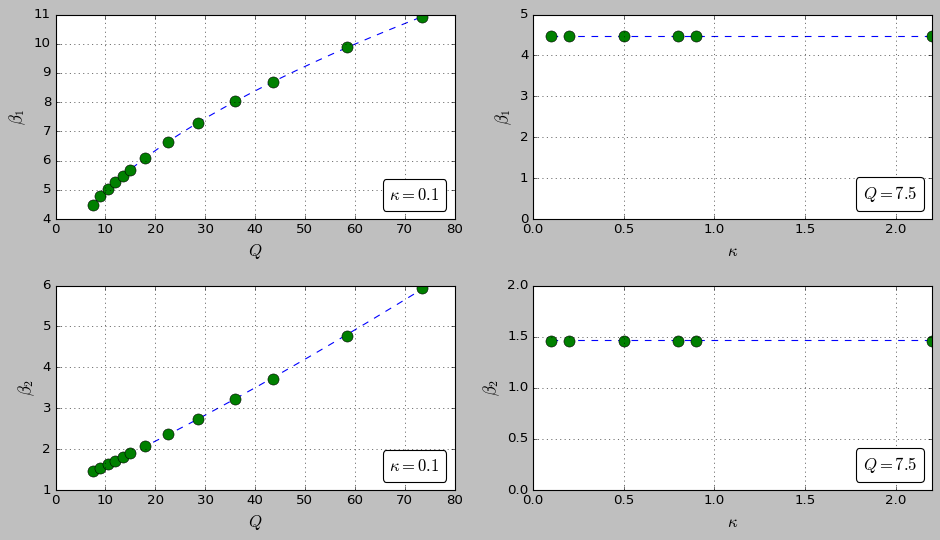

In [19]:
fig, axs = plt.subplots( 2, 2, figsize=(12, 7) )

# beta1 vs. Q for kappa = 0.1
x_exact = dfPrms.query('(kappa == 0.1) & (Q > 6.0)')['Q'].to_list()
y_exact = dfPrms.query('(kappa == 0.1) & (Q > 6.0)')['beta1'].to_list()
x_fit = np.linspace(7.5, 73.5, num=150)
y_fit = beta12Func(x_fit, beta1_prms[0], beta1_prms[1], beta1_prms[2])
axs[0, 0].plot(x_fit, y_fit, '--')
axs[0, 0].plot(x_exact, y_exact, 'o')
axs[0, 0].set_xlabel(r'$Q$')
axs[0, 0].set_ylabel(r'$\beta_1$')
at00 = AnchoredText(r'$\kappa=0.1$', prop=dict(size=15), frameon=True, loc='lower right')
at00.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axs[0, 0].add_artist(at00)

# beta1 vs. kappa for Q = 7.5
x_exact = dfPrms.query('(kappa > 0.0) & (Q == 7.5)')['kappa'].to_list()
y_exact = dfPrms.query('(kappa > 0.0) & (Q == 7.5)')['beta1'].to_list()
y_fit = beta12Func(7.5, beta1_prms[0], beta1_prms[1], beta1_prms[2])
axs[0, 1].plot([0.1, 2.2], [y_fit, y_fit], '--')
axs[0, 1].plot(x_exact, y_exact, 'o')
axs[0, 1].axis([0.0, 2.2, 0.0, 5.0])
axs[0, 1].set_xlabel(r'$\kappa$')
axs[0, 1].set_ylabel(r'$\beta_1$')
at01 = AnchoredText(r'$Q=7.5$', prop=dict(size=15), frameon=True, loc='lower right')
at01.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axs[0, 1].add_artist(at01)

# beta2 vs. Q for kappa = 0.1
x_exact = dfPrms.query('(kappa == 0.1) & (Q > 6.0)')['Q'].to_list()
y_exact = dfPrms.query('(kappa == 0.1) & (Q > 6.0)')['beta2'].to_list()
x_fit = np.linspace(7.5, 73.5, num=150)
y_fit = beta12Func(x_fit, beta2_prms[0], beta2_prms[1], beta2_prms[2])
axs[1, 0].plot(x_fit, y_fit, '--')
axs[1, 0].plot(x_exact, y_exact, 'o')
axs[1, 0].set_xlabel(r'$Q$')
axs[1, 0].set_ylabel(r'$\beta_2$')
at10 = AnchoredText(r'$\kappa=0.1$', prop=dict(size=15), frameon=True, loc='lower right')
at10.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axs[1, 0].add_artist(at10)

# beta2 vs. kappa for Q = 7.5
x_exact = dfPrms.query('(kappa > 0.0) & (Q == 7.5)')['kappa'].to_list()
y_exact = dfPrms.query('(kappa > 0.0) & (Q == 7.5)')['beta2'].to_list()
y_fit = beta12Func(7.5, beta2_prms[0], beta2_prms[1], beta2_prms[2] )
axs[1, 1].plot([0.1, 2.2], [y_fit, y_fit], '--')
axs[1, 1].plot(x_exact, y_exact, 'o')
axs[1, 1].axis([0.0, 2.2, 0.0, 2.0])
axs[1, 1].set_xlabel(r'$\kappa$')
axs[1, 1].set_ylabel(r'$\beta_2$')
at11 = AnchoredText(r'$Q=7.5$', prop=dict(size=15), frameon=True, loc='lower right')
at11.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axs[1, 1].add_artist(at11)

fig.tight_layout()

if print_plots_to_pdf:
    plt.savefig(plots_file_path + 'beta12_vs_q_k.pdf', format="pdf", bbox_inches="tight")
    
plt.show()

<a id='sec5'></a>
## <center><span style="text-transform:uppercase;">V. Approximating the Landau level mixing-incorporated Haldane pseudopotentials</span></center>

Let us visualize how LLM affects the PPs in the lowest LL for $Q=7.5$ and $\kappa\in\{0.5,2.2\}$.

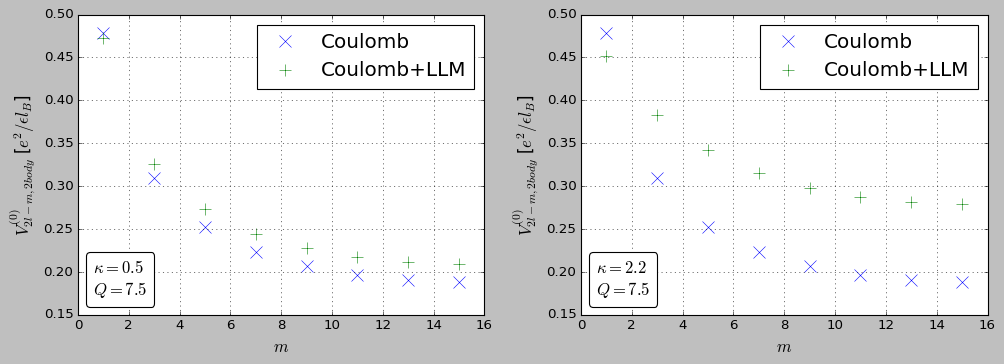

In [20]:
q = 7.5
kappa_list = [0.5, 2.2]

fig, axs = plt.subplots( 1, len(kappa_list), figsize=( 6.4*len(kappa_list), 4.8) )
    
# define the array of deltas for any number of parameters
deltas = []
for j in range(nPrms):
    if j == 0:
        deltas.append( fitM1(1/q) )
    if j == 1:
        deltas.append( fitM3(1/q) )
    if j == 2:
        deltas.append( fitM5(1/q) )
    if j == 3:
        deltas.append( fitM7(1/q) )
    if j > 3: # convergence for m >= 9
        deltas.append( fitM9(1/q) )

# m can be any odd value up to 2Q in lowest Landau level
mArray = list(range(1, int(2*q + 1), 2))

# parameters for Coulomb potential are identically 0
prms0 = ()
for j, delta in enumerate(deltas):
    prms0 = prms0 + (0.0,)

vCoul = []
for j, m in enumerate(mArray):
    qL = (q, 2*q - m)
    vCoul.append( wootenPP(qL, prms0) )

for j, kappa in enumerate(kappa_list):  
    vLlm = []
    for k, m in enumerate(mArray):
        
        # in lowest Landau level L=2l-m, l=|Q|+|n| -> L=2Q-m
        qL = (q, 2*q - m)

        if k < len(deltas):
            vLlm.append(wootenPP(qL, prms0) + kappa * deltas[k])
        else:
            # add m = 9 delta to each potential for m > 9 b/c of convergence
            vLlm.append(wootenPP(qL, prms0) + kappa * deltas[-1])

    axs[j].plot(mArray, vCoul, 'x', label='Coulomb')
    axs[j].plot(mArray, vLlm, '+', label='Coulomb+LLM')
    axs[j].set_xlabel(r'$m$')
    axs[j].set_ylabel(r'$V^{(0)}_{2l-m,2body}$ [$e^2/\epsilon l_B$]')
    at = AnchoredText('\n'.join( (f'$\kappa={kappa:.1f}$', f'$Q={q:.1f}$') ), prop=dict(size=15), frameon=True, 
        loc='lower left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    axs[j].add_artist(at)
    axs[j].legend(loc='upper right')

fig.tight_layout()

if print_plots_to_pdf:
    plt.savefig(plots_file_path + 'coul_llm_vs_m.pdf', format="pdf", bbox_inches="tight")
    
plt.show()

We can see from the plot above that the gaps to excited PPs should be decreasing as a function of $\kappa$. Let us now visualize the exact fit of the effective potential to the PPs corresponding to the first four odd $m$ values.

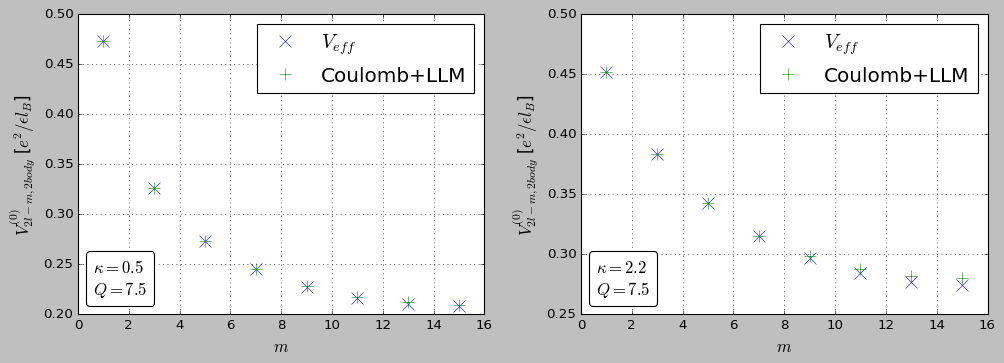

In [21]:
q = 7.5
kappa_list = [0.5, 2.2]

fig, axs = plt.subplots( 1, len(kappa_list), figsize=( 6.4*len(kappa_list), 4.8) )
    
# define the array of deltas for any number of parameters
deltas = []
for j in range(nPrms):
    if j == 0:
        deltas.append( fitM1(1/q) )
    if j == 1:
        deltas.append( fitM3(1/q) )
    if j == 2:
        deltas.append( fitM5(1/q) )
    if j == 3:
        deltas.append( fitM7(1/q) )
    if j > 3: # convergence for m >= 9
        deltas.append( fitM9(1/q) )

# m can be any odd value up to 2Q in lowest Landau level
mArray = list(range(1, int(2*q + 1), 2))

# parameters for Coulomb force are identically 0
prms0 = ()
for j, delta in enumerate(deltas):
    prms0 = prms0 + (0.0,)

vCoul = []
for j, m in enumerate(mArray):
    qL = (q, 2*q - m)
    vCoul.append( wootenPP(qL, prms0) )

for j, kappa in enumerate(kappa_list):  
    vLlm = []
    for k, m in enumerate(mArray):
        
        # in lowest Landau level L=2l-m, l=|Q|+|n| -> L=2Q-m
        qL = (q, 2*q - m)

        if k < len(deltas):
            vLlm.append(wootenPP(qL, prms0) + kappa * deltas[k])
        else:
            # add m = 9 delta to each potential for m > 9 b/c of convergence
            vLlm.append(wootenPP(qL, prms0) + kappa * deltas[-1])
            
    dfTmp = dfPrms.query('(Q == @q) & (kappa == @kappa)')
    prms = [ dfTmp['b1'].values[0], dfTmp['b2'].values[0], dfTmp['beta1'].values[0], dfTmp['beta2'].values[0] ]
    dfPP = vqlDF(q, kappa, prms)
    vQL = dfPP['V_Q(L)'].to_list()
    vQL.reverse()

    axs[j].plot(mArray, vQL, 'x', label='$V_{eff}$')
    axs[j].plot(mArray, vLlm, '+', label='Coulomb+LLM')
    axs[j].set_xlabel(r'$m$')
    axs[j].set_ylabel(r'$V^{(0)}_{2l-m,2body}$ [$e^2/\epsilon l_B$]')
    at = AnchoredText('\n'.join( (f'$\kappa={kappa:.1f}$', f'$Q={q:.1f}$') ), prop=dict(size=15), frameon=True, 
        loc='lower left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    axs[j].add_artist(at)
    axs[j].legend(loc='upper right')

fig.tight_layout()

if print_plots_to_pdf:
    plt.savefig(plots_file_path + 'vEff_vs_m.pdf', format="pdf", bbox_inches="tight")
    
plt.show()

We can see that $V_{eff}$ fits the LLM-incorporated PPs exactly for the first four odd $m$ values, then starts to slowly pull up as $m$ and/or $\kappa$ increase. Since fitting the first four values exactly is computationally complex, we will instead be using the functions for each parameter $b_i(Q,\kappa)$ and $\beta_i(Q)$ developed in Sec. [IV](#sec4) to approximate the LLM-incorporated PPs. We can inspect the error this introduces below.

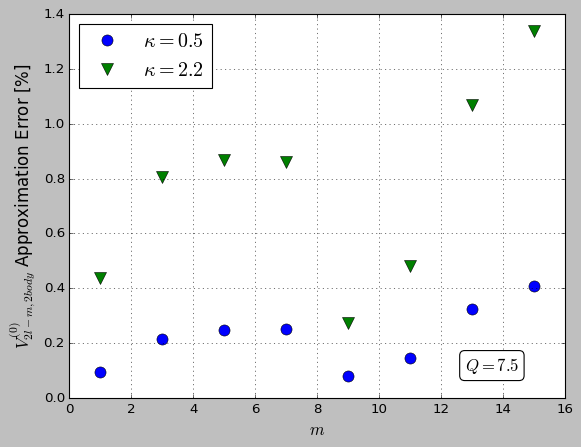

In [22]:
q = 7.5
kappa_list = [0.5, 2.2]
    
# define the array of deltas for any number of parameters
deltas = []
for j in range(nPrms):
    if j == 0:
        deltas.append( fitM1(1/q) )
    if j == 1:
        deltas.append( fitM3(1/q) )
    if j == 2:
        deltas.append( fitM5(1/q) )
    if j == 3:
        deltas.append( fitM7(1/q) )
    if j > 3: # convergence for m >= 9
        deltas.append( fitM9(1/q) )

# m can be any odd value up to 2Q in lowest Landau levl
mArray = list(range(1, int(2*q + 1), 2))

# parameters for Coulomb force are identically 0
prms0 = ()
for j, delta in enumerate(deltas):
    prms0 = prms0 + (0.0,)

vCoul = []
for j, m in enumerate(mArray):
    qL = (q, 2*q - m)
    vCoul.append( wootenPP(qL, prms0) )
    
markers = ['o', 'v']
for j, kappa in enumerate(kappa_list):  
    vLlm = []
    for k, m in enumerate(mArray):
        
        # in lowest Landau level L=2l-m, l=|Q|+|n| -> L=2Q-m
        qL = (q, 2*q - m)

        if k < len(deltas):
            vLlm.append(wootenPP(qL, prms0) + kappa * deltas[k])
        else:
            # add m = 9 delta to each potential for m > 9 b/c of convergence
            vLlm.append(wootenPP(qL, prms0) + kappa * deltas[-1])
            
    qKappa = (q, kappa)
    b1 = b12Func(qKappa, b1_prms[0], b1_prms[1], b1_prms[2])
    b2 = b12Func(qKappa, b2_prms[0], b2_prms[1], b2_prms[2])
    beta1 = beta12Func(q, beta1_prms[0], beta1_prms[1], beta1_prms[2])
    beta2 = beta12Func(q, beta2_prms[0], beta2_prms[1], beta2_prms[2])

    prms = [b1, b2, beta1, beta2]
    dfPP = vqlDF(q, kappa, prms)
    vQL = dfPP['V_Q(L)'].to_list()
    vQL.reverse()
    
    fit_prms_pct_err = []
    for vQL_i, vLlm_i in zip(vQL, vLlm):
        fit_prms_pct_err.append( abs(vQL_i - vLlm_i)/vLlm_i * 100 )

    plt.plot(mArray, fit_prms_pct_err, markers[j], label=f'$\kappa={kappa}$')
    plt.xlabel(r'$m$')
    plt.ylabel(r'$V^{(0)}_{2l-m,2body}$ Approximation Error [%]')

plt.text( 12.75, 0.1, f'$Q={q:.1f}$', size=15, bbox=dict(boxstyle="round", ec='black', fc='white') )  
plt.legend(loc='upper left')

if print_plots_to_pdf:
    plt.savefig(plots_file_path + 'pp_err_vs_m.pdf', format="pdf", bbox_inches="tight")
    
plt.show()

Even for our largest LLM parameter, $\kappa=2.2$, the LLM-incorporated PPs approximated by the fitted parameters for the first four odd $m$ values with $Q=7.5$ are still accurate to within 1%. The accuracy increases as a function of $Q$, however it decreases for larger $m$ values. Further studies need to be done to observe how this quantitately affects the accuracy of the exciton dispersion calculated by the MC code. We now have a much less computationally complex way of calculating the effective potential in the MC code for two-body interactions in the lowest LL that incorporate LLM into FQH states. Let us see what the effective potential looks like in real-space as a function of $r$.

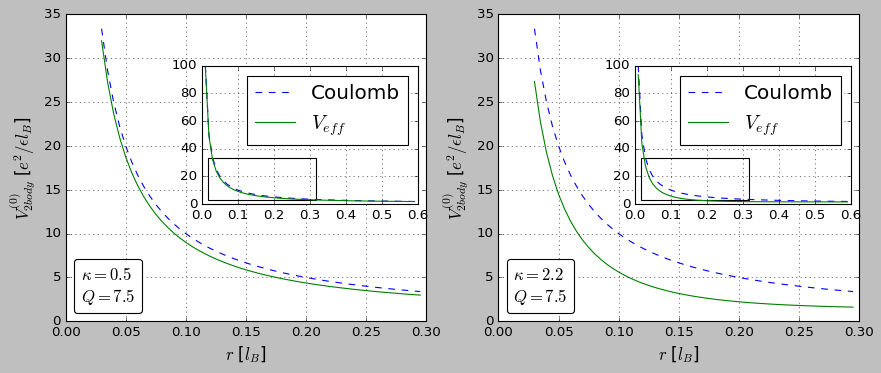

In [23]:
q = 7.5
kappa_list = [0.5, 2.2]

fig, axs = plt.subplots( 1, len(kappa_list), figsize=( 6.4*len(kappa_list), 4.8) )
    
# define the array of deltas for any number of parameters
deltas = []
for j in range(nPrms):
    if j == 0:
        deltas.append( fitM1(1/q) )
    if j == 1:
        deltas.append( fitM3(1/q) )
    if j == 2:
        deltas.append( fitM5(1/q) )
    if j == 3:
        deltas.append( fitM7(1/q) )
    if j > 3: # convergence for m >= 9
        deltas.append( fitM9(1/q) )

# m can be any odd value up to 2Q in the lowest Landau level
mArray = list(range(1, int(2*q + 1), 2))

# parameters for Coulomb force are identically 0
prms0 = ()
for j, delta in enumerate(deltas):
    prms0 = prms0 + (0.0,)

vCoul = []
for j, m in enumerate(mArray):
    
    # in lowest Landau level L=2l-m, l=|Q|+|n| -> L=2Q-m
    qL = (q, 2*q - m)
    
    vCoul.append( wootenPP(qL, prms0) )

for j, kappa in enumerate(kappa_list):  
    qKappa = (q, kappa)
    b1 = b12Func(qKappa, b1_prms[0], b1_prms[1], b1_prms[2])
    b2 = b12Func(qKappa, b2_prms[0], b2_prms[1], b2_prms[2])
    beta1 = beta12Func(q, beta1_prms[0], beta1_prms[1], beta1_prms[2])
    beta2 = beta12Func(q, beta2_prms[0], beta2_prms[1], beta2_prms[2])
    prms = [b1, b2, beta1, beta2]
    r = np.arange(0.03, 0.3, 0.005)

    axs[j].plot(r, 1/r, '--')
    axs[j].plot(r, vEff(r, prms), '-')
    axs[j].set_xlabel(r'$r$ [$l_B$]')
    axs[j].set_ylabel(r'$V^{(0)}_{2body}$ [$e^2/\epsilon l_B$]')
    at = AnchoredText('\n'.join( (f'$\kappa={kappa:.1f}$', f'$Q={q:.1f}$') ), prop=dict(size=15), frameon=True, 
        loc='lower left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    axs[j].add_artist(at)

    axins = inset_axes(axs[j], width="100%", height="100%",
                   bbox_to_anchor=(.35, .35, .6, .45),
                   bbox_transform=axs[j].transAxes, loc=3)
    r = np.arange(0.01, 0.6, 0.01)
    axins.plot(r, 1/r, '--', label='Coulomb')
    axins.plot(r, vEff(r, prms), '-', label='$V_{eff}$')
    axins.add_patch(plt.Rectangle((.03, 0.03), .5, .3, ls="-", ec="k", fc="none", transform=axins.transAxes)) 
    axins.legend(loc='upper right')

if print_plots_to_pdf:
    plt.savefig(plots_file_path + 'vEff_vs_r.pdf', format="pdf", bbox_inches="tight")
    
plt.show()

We can see for $Q=7.5$, the effective potential dips below the Coulomb potential before rising above it and then quickly converging to it. This behavior gets more pronounced as $\kappa$ increases. We can better visualize this by plotting the difference between the approximated effective potential and the Coulomb potential, $V_{eff}-V_{Coul}$, for different values of $\kappa$ below. We would like to direct the reader to Appendix [A](#appA) for a more thorough discussion of the behavior of the effective potential in real-space, including as a function of $Q$.

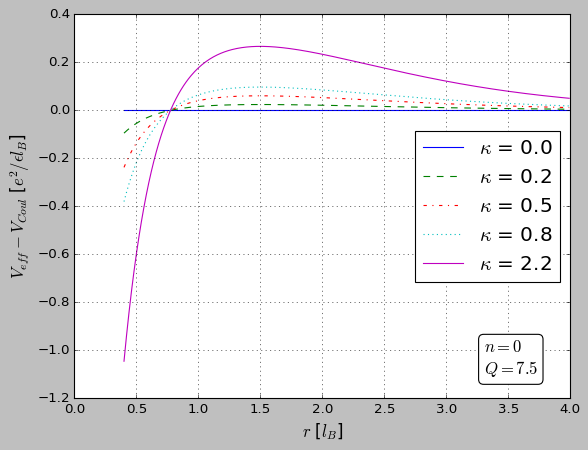

In [24]:
q = 7.5
kappa_list = [0.0, 0.2, 0.5, 0.8, 2.2]

r = np.arange(0.4, 4, 0.01)
linestyles = ['solid', 'dashed', 'dashdot', 'dotted', '-']

for i, kappa in enumerate(kappa_list):
    qKappa = (q, kappa)
    b1 = b12Func(qKappa, b1_prms[0], b1_prms[1], b1_prms[2])
    b2 = b12Func(qKappa, b2_prms[0], b2_prms[1], b2_prms[2])
    beta1 = beta12Func(q, beta1_prms[0], beta1_prms[1], beta1_prms[2])
    beta2 = beta12Func(q, beta2_prms[0], beta2_prms[1], beta2_prms[2])
    prms = [b1, b2, beta1, beta2]

    plt.plot(r, (vEff(r, prms)-1/r), linestyle=linestyles[i], label=f'$\kappa$ = {kappa:.1f}')
        
plt.xlabel(r'$r$ [$l_B$]')
plt.ylabel(r'$V_{eff}-V_{Coul}$ [$e^2/\epsilon l_B$]')
plt.text( 3.3, -1.1, f'$n=0$\n$Q={q:.1f}$', size=15, bbox=dict(boxstyle="round", ec='black', fc='white') )  
plt.legend(loc='right')

if print_plots_to_pdf:
    plt.savefig(plots_file_path + 'vEff_minus_vCoul_vs_r.pdf', format="pdf", bbox_inches="tight")
    
plt.show()

<a id='sec6'></a>
## <center><span style="text-transform:uppercase;">VI. Composite fermion-exciton dispersion for electron filling factor 1/3</span></center>

After plugging the PP parameter equations and the <code>RANGE</code> equation (see Appendix [B](#appB)) into the MC code, the energy gaps were observed to diverge. We noticed that the MHA in the code was using the ground state ($L_0$) wavefunction to calculate the probability weight function for acceptance sampling. We experimeted with instead using the current state ($L_i$) wavefunction (which increased computational complexity) as well as using just the wavefunction of the lowest energy at $L=N$ ($L_{max}$). We can observe the exciton dispersion for each of these different energy states when used for acceptance sampling ($L_{sample}$) in the lowest Landau level with $\nu=1/3$, $N=11$, and $\kappa=0.0$ below, where the error bars are within the size of the markers.

In [25]:
df_wave_fun = pd.read_csv('data/wavefxns_for_sampling.csv')
df_wave_fun.head()

,ITER,N,L,kl,gapSampL0,ErrGapSampL0,gapSampLMax,errGapSampLMax,gapSampL,errGapSampL
0,1000000,11,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1000000,11,2,0.516398,0.144685,0.000156,0.141586,0.000285,0.144685,0.000156
2,1000000,11,3,0.774597,0.122551,0.000189,0.120048,0.000439,0.122806,0.000092
3,1000000,11,4,1.032796,0.097181,0.000276,0.095804,0.000339,0.098048,0.000072
4,1000000,11,5,1.290994,0.079375,0.000093,0.074637,0.000523,0.077205,0.001349


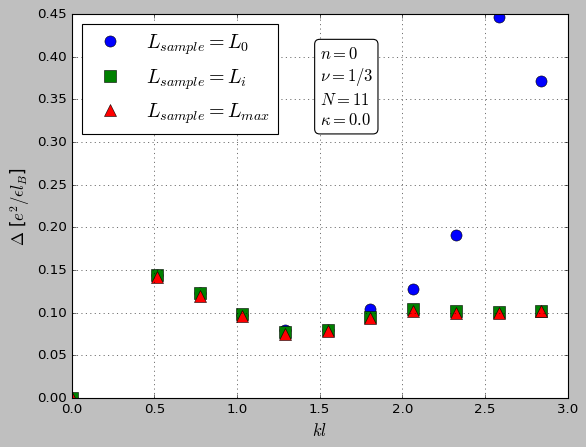

In [26]:
kl = df_wave_fun['kl'].to_list()
l0_gaps = df_wave_fun['gapSampL0'].to_list()
l_i_gaps = df_wave_fun['gapSampL'].to_list()
l_max_gaps = df_wave_fun['gapSampLMax'].to_list()

plt.plot(kl, l0_gaps, 'o', label='$L_{sample}=L_0$')
plt.plot(kl, l_i_gaps, 's', label='$L_{sample}=L_i$')
plt.plot(kl, l_max_gaps, '^', label='$L_{sample}=L_{max}$')
plt.xlabel('$kl$')
plt.ylabel('$\Delta$ [$e^2/\epsilon l_B$]')
plt.text( 1.5, 0.32, '\n'.join( (r'$n=0$', r'$\nu=1/3$', r'$N=11$', r'$\kappa=0.0$') ), size=15, 
    bbox=dict(boxstyle="round", ec='black', fc='white') )
plt.legend(loc='upper left')

if print_plots_to_pdf:
    plt.savefig(plots_file_path + 'exc_disp_samples.pdf', format="pdf", bbox_inches="tight")
    
plt.show()

We can see that qualitatively using $L_{max}$ to calculate the probability weight function for acceptance sampling provides close accuracy to using each individual state's wavefunctions with significantly less computational complexity. We can quantitately inspect the percent error difference between the two below.

In [27]:
err_list = []
for l_i, l_max in zip(l_i_gaps[1:], l_max_gaps[1:]):
    err_list.append(abs( ( l_i - l_max)/l_i ) * 100)

print( '\n'.join( (f'L = N acceptance sampling % error', f'mean: {fmean(err_list)}', 
    f'standard deviation: {stdev(err_list)}', f'max: {max(err_list)}') ) )

L = N acceptance sampling % error
mean: 2.0047427170635688
standard deviation: 0.9386485755797144
max: 3.326209442393629


Further studies will need to be done comparing probability weight function densities for each state to explore the divergence of the exciton dispersion when using the ground state wavefunction for acceptance sampling. Using $L_{max}$ below, we get the expected exciton dispersion from the MC code in the lowest LL for $\nu=1/3$, $\kappa=0.0$, and $N=20$.

In [28]:
df_large_n = pd.read_csv('data/hpc_large_n.csv')
df_large_n.head()

,N,ITER,NLL,kappa,transpGapQ,Q,b1,b2,beta1,beta2,RANGE,filling,spin,accRatio,L,nrgPerPtcl,errPerPtcl,gapErr,kl,gap
0,20,10000000,1,0.0,0,28.5,-0.0,0.0,7.290315,2.731999,0.035407,0.333,1,0.466353,0,1.452467,0.000015,0.000000,0.000000,0.000000
1,20,10000000,1,0.0,0,28.5,-0.0,0.0,7.290315,2.731999,0.035407,0.333,1,0.466353,2,1.459806,0.000042,0.000715,0.374634,0.146766
2,20,10000000,1,0.0,0,28.5,-0.0,0.0,7.290315,2.731999,0.035407,0.333,1,0.466353,3,1.459184,0.000030,0.000500,0.561951,0.134338
3,20,10000000,1,0.0,0,28.5,-0.0,0.0,7.290315,2.731999,0.035407,0.333,1,0.466353,4,1.458491,0.000049,0.000849,0.749269,0.120473
4,20,10000000,1,0.0,0,28.5,-0.0,0.0,7.290315,2.731999,0.035407,0.333,1,0.466353,5,1.457587,0.000054,0.000957,0.936586,0.102399


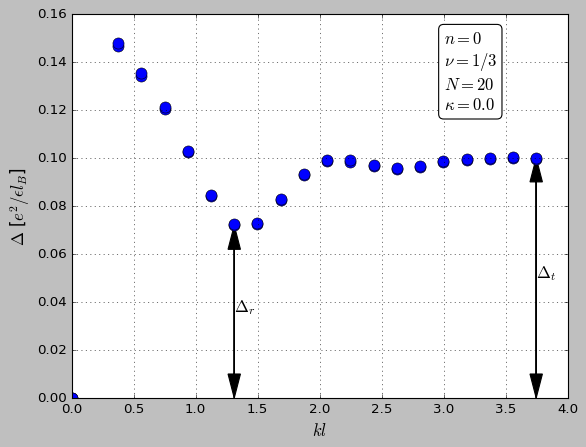

In [29]:
kl = df_large_n['kl'].to_list()
gaps = df_large_n['gap'].to_list()

plt.plot(kl, gaps, 'o')
plt.xlabel('$kl$')
plt.ylabel('$\Delta$ [$e^2/\epsilon l_B$]')
plt.text( 3., 0.12, '\n'.join( (r'$n=0$', r'$\nu=1/3$', r'$N=20$', r'$\kappa=0.0$') ), size=15, 
    bbox=dict(boxstyle="round", ec='black', fc='white') )

# draw arrows
roton_gap = min([gap for gap in gaps if gap > 0.])
roton_idx = gaps.index(roton_gap)
roton_kl = kl[roton_idx]
plt.arrow(roton_kl, 0., 0., roton_gap, head_width=0.1, head_length=0.01, color='k', length_includes_head=True)
plt.arrow(roton_kl, roton_gap, 0., -roton_gap, head_width=0.1, head_length=0.01, color='k', length_includes_head=True)
plt.text(roton_kl, roton_gap/2, r'$\Delta_r$', size=15)
transp_gap = gaps[-1]
transp_kl = kl[-1]
plt.arrow(transp_kl, 0., 0., transp_gap, head_width=0.1, head_length=0.01, color='k', length_includes_head=True)
plt.arrow(transp_kl, transp_gap, 0., -transp_gap, head_width=0.1, head_length=0.01, color='k', 
    length_includes_head=True)
plt.text(transp_kl, transp_gap/2, r'$\Delta_t$', size=15)

if print_plots_to_pdf:
    plt.savefig(plots_file_path + 'exc_disp_n_20.pdf', format="pdf", bbox_inches="tight")

plt.show()

<a id='sec7'></a>
## <center><span style="text-transform:uppercase;">VII. Benchmarking the composite fermion-exciton dispersion against exact diagonalization</span></center>

Let us import the energy gap data from the MC and ED codes for $6\leq N\leq10$ and $\kappa\in\{0.0,0.1,0.2\}$.

In [30]:
dfEGaps = pd.read_csv('data/mc_energy_gap_benchmark.csv')

dfEGaps.head()

,N,ITER,NLL,kappa,transpGapQ,Q,b1,b2,beta1,beta2,...,spin,accRatio,L,nrgPerPtcl,errPerPtcl,gapErr,edNrg,kl,mcGapBm,edGapBm
0,6,1000000,1,0.0,0,7.0,0.0,0.0,4.388483,1.442076,...,1,0.533608,0,0.645422,0.000033,0.000000,3.872944,0.000000,0.000000,0.000000
1,6,1000000,1,0.0,0,7.0,0.0,0.0,4.388483,1.442076,...,1,0.533608,2,0.668196,0.000071,0.000447,4.007292,0.755929,0.136643,0.134348
2,6,1000000,1,0.0,0,7.0,0.0,0.0,4.388483,1.442076,...,1,0.533608,3,0.661924,0.000059,0.000326,3.971496,1.133893,0.099011,0.098552
3,6,1000000,1,0.0,0,7.0,0.0,0.0,4.388483,1.442076,...,1,0.533608,4,0.659202,0.000063,0.000290,3.957059,1.511858,0.082681,0.084115
4,6,1000000,1,0.0,0,7.0,0.0,0.0,4.388483,1.442076,...,1,0.533608,5,0.663178,0.000051,0.000316,3.980387,1.889822,0.106534,0.107443


Let us plot the energy gaps as a function of $kl$ for all $N$, $\kappa$.

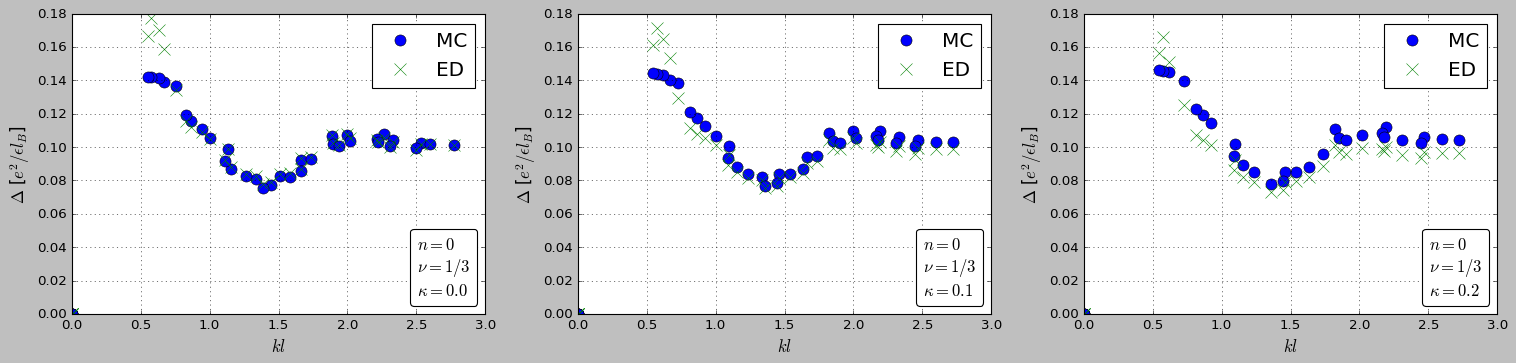

In [31]:
kappa_list = [0.0, 0.1, 0.2]

fig, axs = plt.subplots( 1, len(kappa_list), figsize=( 6.4*len(kappa_list), 4.8) )

for i in range( len(kappa_list) ):
    kappa = kappa_list[i]
    
    df = dfEGaps.query('(kappa == @kappa)')
    
    kl = df['kl'].to_list()
    mc_gaps = df['mcGapBm'].to_list()
    ed_gaps = df['edGapBm'].to_list()
    
    axs[i].plot(kl, mc_gaps, 'o', label='MC')
    axs[i].plot(kl, ed_gaps, 'x', label='ED')
    axs[i].legend(loc='upper right')
    axs[i].set_xlabel(r'$kl$')
    axs[i].set_ylabel(r'$\Delta$ [$e^2/\epsilon l_B$]')
    
    at = AnchoredText(f'$n=0$\n$\\nu=1/3$\n$\kappa={kappa:.1f}$', prop=dict(size=15), frameon=True, loc='lower right')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    axs[i].add_artist(at)

fig.tight_layout()

if print_plots_to_pdf:
    plt.savefig(plots_file_path + 'exc_disp_kappas.pdf', format="pdf", bbox_inches="tight")
    
plt.show()

We can split this up to view the contribution from each individual $N$ to the MC gaps for $\kappa=0.0$.

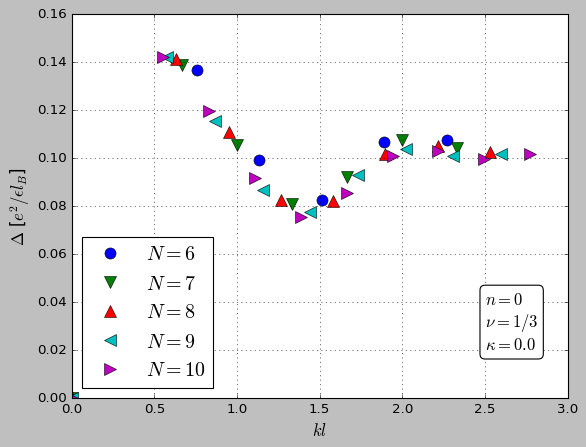

In [32]:
kappa = 0.0
markers = ['o', 'v', '^', '<', '>']
n_array = dfEGaps['N'].unique()

for i, n in enumerate(n_array):
    df = dfEGaps.query('(N == @n) & (kappa == @kappa)')
    kl = df['kl'].to_list()
    gaps = df['mcGapBm'].to_list()
    plt.plot(kl, gaps, markers[i], label=f'$N={n}$')

plt.xlabel(r'$kl$')
plt.ylabel(r'$\Delta$ [$e^2/\epsilon l_B$]')
plt.legend(loc='lower left')
plt.text(2.5, 0.02, f'$n=0$\n$\\nu=1/3$\n$\kappa={kappa:.1f}$',  size=15, 
    bbox=dict(boxstyle="round", ec='black', fc='white') )

if print_plots_to_pdf:
    plt.savefig(plots_file_path + 'exc_disp_ns.pdf', format="pdf", bbox_inches="tight")
    
plt.show()

We can observe what happens to the transport gap for $\nu=1/3$ in the lowest LL as a function of $\kappa$.

In [33]:
df_transport_gap = pd.read_csv('data/transport_gaps.csv')
df_transport_gap.head()

,N,E_0_mc,E_L_mc,E_0_ed,E_L_ed,kappa,mc_txp_gap,ed_txp_gap
0,10,9.28253,9.38404,9.282526,9.384017,0.0,0.10151,0.101491
1,10,9.30498,9.40786,9.365359,9.464343,0.1,0.10288,0.098984
2,10,9.32743,9.43168,9.448193,9.544669,0.2,0.10425,0.096476


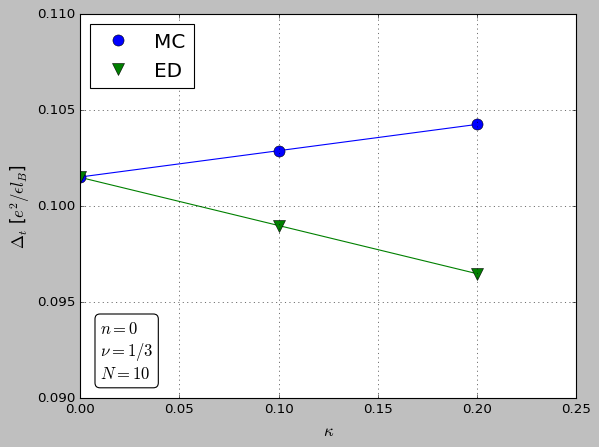

In [34]:
kappas = df_transport_gap['kappa'].to_list()
mc_txp_gaps = df_transport_gap['mc_txp_gap'].to_list()
ed_txp_gaps = df_transport_gap['ed_txp_gap'].to_list()

plt.axis([0., 0.25, 0.09, .11])
plt.plot(kappas, mc_txp_gaps, 'b')
plt.plot(kappas, ed_txp_gaps, 'g')
plt.plot(kappas, mc_txp_gaps, 'bo', label='MC')
plt.plot(kappas, ed_txp_gaps, 'gv', label='ED')
plt.xlabel(r'$\kappa$')
plt.ylabel(r'$\Delta_t$ [$e^2/\epsilon l_B$]')
plt.legend(loc='upper left')
plt.text( 0.01, 0.091, '$n=0$\n$\\nu=1/3$\n$N=10$', size=15, bbox=dict(boxstyle="round", ec='black', fc='white') )

if print_plots_to_pdf:
    plt.savefig(plots_file_path + 'transp_gaps_vs_kappa.pdf', format="pdf", bbox_inches="tight")
    
plt.show()

We can see that the transport gaps calculated by the MC code are increasing slightly as a function of $\kappa$ when they should be decreasing.

<a id='sec8'></a>
## <center><span style="text-transform:uppercase;">VIII. Sources of error</span></center>

To look for the source of this error, let us examine the normalized histogram of the probability weight function from which the MC code sampled its $r$ values and compare it to the graph of $V_{eff}-V_{Coul}$ from Sec. [IV](#sec5).

In [35]:
dfRSmplN11K01 = pd.read_csv('data/rVSamplingN11K0.1.csv')
dfRSmplN11K01.head()

,r,Veff
0,6.583829,0.151897
1,2.482611,0.557918
2,7.154364,0.697697
3,5.389279,0.883313
4,7.659419,1.013873


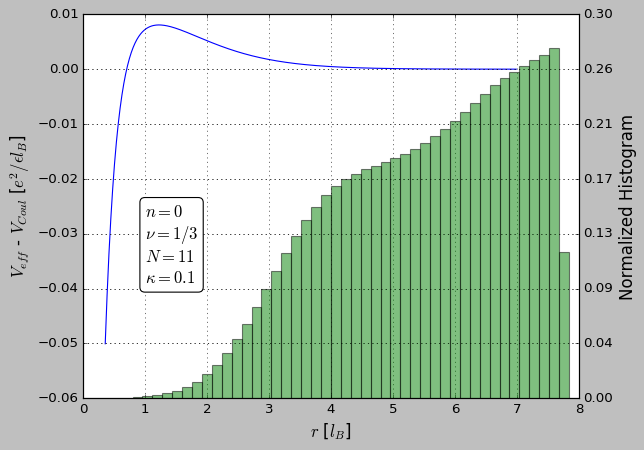

In [36]:
n, kappa = 11, 0.1

# calculations for vEff - vCoul
q = (3*n - 3) / 2        
qKappa = (q, kappa)
b1 = b12Func(qKappa, b1_prms[0], b1_prms[1], b1_prms[2])
b2 = b12Func(qKappa, b2_prms[0], b2_prms[1], b2_prms[2])
beta1 = beta12Func(q, beta1_prms[0], beta1_prms[1], beta1_prms[2])
beta2 = beta12Func(q, beta2_prms[0], beta2_prms[1], beta2_prms[2])
prms = [b1, b2, beta1, beta2]
r = np.arange(0.36, 7, 0.01)

# plot vEff - vCoul
fig, ax1 = plt.subplots()
ax1.set_ylabel(r'$V_{eff}$ - $V_{Coul}$ [$e^2/\epsilon l_B$]')
ax1.set_xlabel(r'$r$ [$l_B$]')
ax1.plot(r, vEff(r, prms)-1/r)
ax1.tick_params(axis='y')

ax1.set_ylim(-0.06, 0.01)
ax1.set_yticks( np.linspace(-0.06, 0.01, 8) )

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# plot r sample histogram
ax2.set_xlabel('r')
ax2.set_ylabel('Normalized Histogram')
ax2.hist(dfRSmplN11K01['r'], bins = 50, range=(0, 8), density=True, alpha=0.5, color='g')
ax2.tick_params(axis='y')

ax2.set_ylim(0.00, 0.30)
ax2.set_yticks( np.linspace(0.00, 0.30, 8) )
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax2.text( 1., 0.09, '\n'.join( (r'$n=0$', r'$\nu=1/3$', r'$N=11$', r'$\kappa=0.1$') ), size=15, 
    bbox=dict(boxstyle="round", ec='black', fc='white') )

if print_plots_to_pdf:
    plt.savefig(plots_file_path + 'r_sample_hist.pdf', format="pdf", bbox_inches="tight")

plt.show()

We can see from the plot above that the exciton dispersion as a function of $\kappa$ is not incorporating LLM because it is mostly sampling from the radii where the difference from the Coulomb potential has vanished. Future studies need to be done developing an algorithm that will sample from these critical radii to improve the accuracy of MC FQH energy gap calculations for graphene. There was an effort made to artifically insert these states via an anologous process to Laplace smoothing in the Naive Bayes model of machine learning, but the MHA proved to be too sensitive to any small changes to provide a useful path to take with these kinds of adjustments.

<a id='sec9'></a>
## <center><span style="text-transform:uppercase;">IX. Conclusions</span></center>

In this notebook we fit two-body, perturbative, LLM-incorporated PP correction data in the lowest LL in order to map a two-body, real-space effective potential to the Haldane sphere and incorporate LLM. We then fit the effective potential fitting parameters and analyzed the approximated LLM-incorporated PP error. We used these results to calculate the CF-exciton dispersion for $\nu=1/3$ in the lowest LL via a variational MC method and benchmarked the results against exact diagonalization. We deduced that the MC exciton dispersion produced the opposite trend of ED as a function of $\kappa$ because the MHA was not sampling the less likely, more dense states where LLM most affects the potential. Future studies need to be done to develop an algorithm that will sample the more dense states so that realistic FQHE energy gaps in graphene can be calculated in the thermodynamic limit as a function of $0.5<\kappa\leq2.2$ for $\nu\in\{1/3,2/5,3/7,4/9,5/11,...\}$, and eventually three-body particle-hole symmetry breaking terms for higher LLs and other materials.

## <center><span style="text-transform:uppercase;">Acknowledgments</span></center>

We would like to thank the Office of Research and Sponsored Programs at California State University Long Beach and the Google Summer Research Assistantship for research funding. We would also like to thank Vito Scarola for the MC code.

<a id='appA'></a>
## <center>Appendix A: Properties of the effective potential in real-space</center>

We can see from the graph of $V_{eff}-V_{Coul}$ vs $r$ in the lowest LL in Sec. [V](#sec5) that the difference between the effective and Coulomb potentials for $Q=7.5$ increases in magnitude as a function of $\kappa$. We can also notice that the differences for every $\kappa$ value converge to 0 at $r\approx0.8$. Let us explore what is causing this and solve for that value of $r$. From the form of the effective potential in Sec. [IV](#sec4), we have $V_{eff}-V_{Coul}=b_1e^{-\beta_1r}+b_2r^2e^{-\beta_2r}$. This expression depends linearly on $b_i$, which depend linearly on $\kappa$, and on $\beta_i$, which do not depend on $\kappa$, so the $\kappa$ dependence of $r(V_{eff}=V_{Coul})$ is cancelled out. We can solve via SymPy the exact value of $r(V_{eff}=V_{Coul})$ below.

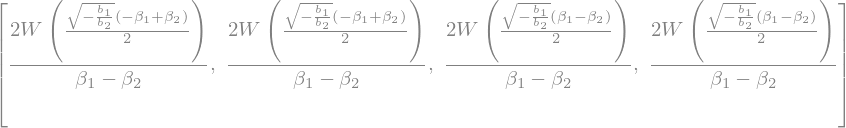

In [37]:
b1, b2, beta1, beta2, r, Q = symbols('b1 b2 beta1 beta2 r Q')
expr = solve(b1*exp(-beta1*r)+b2*r**2*exp(-beta2*r), r)
expr

We can use the following sample parameter values to determine which function to use: $b_1(7.5, 2.2)=-6.8795038127598644$, $b_2(7.5, 2.2)=1.105104095426752$, $\beta_1(7.5)=4.485793127294407$ and $\beta_2(7.5)=1.4685131341239666$. Since $\beta_1>\beta_2$, we have $r(V_{eff}=V_{Coul})=\frac{2}{\beta_1-\beta_2}W\left(\frac{\beta_1-\beta_2}{2}\sqrt{\frac{-b_1}{b_2}}\right)$, where $W$ is the Lambert W function. We can plug in these parameter values to determine the expression for $r(V_{eff}=V_{Coul},Q)$, find the value $r(V_{eff}=V_{Coul},7.5)$, and plot $r(V_{eff}=V_{Coul},Q)$.

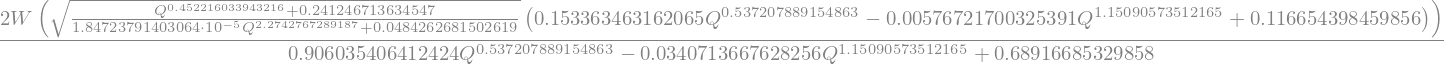

In [38]:
expr_q = simplify( expr[2].subs([
                        (b1, (b1_prms[0]*Q**b1_prms[1]+b1_prms[2])*kappa), 
                        (b2, (b2_prms[0]*Q**b2_prms[1]+b2_prms[2])*kappa),
                        (beta1, beta1_prms[0]*Q**beta1_prms[1]+beta1_prms[2]), 
                        (beta2, beta2_prms[0]*Q**beta2_prms[1]+beta2_prms[2])
                                ])
                 )
expr_q

In [39]:
display( Latex( f'$r(V_{{eff}}=V_{{Coul}},7.5)={expr_q.subs(Q, 7.5)}$') )

<IPython.core.display.Latex object>

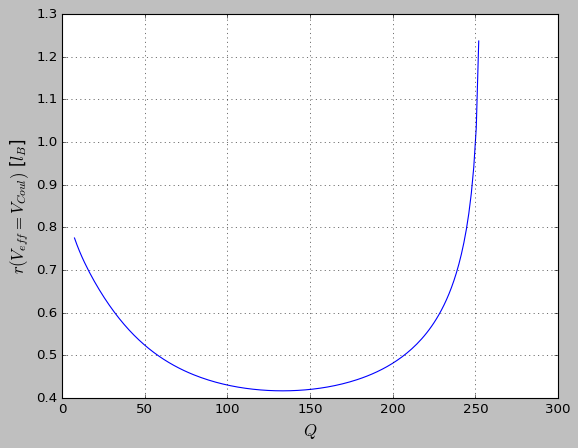

In [40]:
q_array = np.linspace(7.5, 252., num=164) # Q values for nu = 1/3, 6 <= N <= 169 (upper limit for convergence)

r_vEff_eq_vCoul = []
for q_val in q_array:
    r_vEff_eq_vCoul.append( expr_q.subs(Q, q_val) )
    
plt.plot(q_array, r_vEff_eq_vCoul)
plt.xlabel(r'$Q$')
plt.ylabel(r'$r(V_{eff}=V_{Coul})$ [$l_B$]')

if print_plots_to_pdf:
    plt.savefig(plots_file_path + 'r_vEff_eq_vCoul_vs_q.pdf', format="pdf", bbox_inches="tight")
    
plt.show()

We can see that $r(V_{{eff}}=V_{{Coul}},Q)$ starts to diverge near $Q\approx253.5$, which for $\nu=1/3$ in the lowest LL corresponds to $N=169$. It appears that for $Q\geq253.5$, $V_{eff}$ starts below $V_{Coul}$ but then takes an arbitrarily long time to rise above it, although converging to it quickly (for $Q=252.0$, $V_{eff}$ is within 1% of $V_{Coul}$ for all points $r\gtrsim0.345$). We can see this behavior below for different $Q$ values and $\kappa=2.2$.

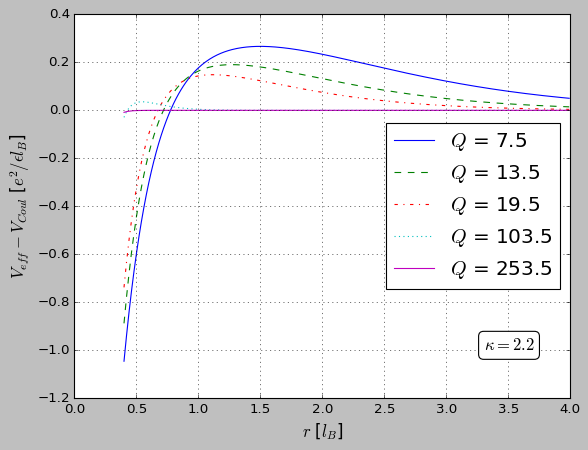

In [41]:
q_list = [7.5, 13.5, 19.5, 103.5, 253.5]
kappa = 2.2

r = np.arange(0.4, 4, 0.01)
linestyles = ['solid', 'dashed', 'dashdot', 'dotted', '-']

for i, q in enumerate(q_list):
    qKappa = (q, kappa)
    b1 = b12Func(qKappa, b1_prms[0], b1_prms[1], b1_prms[2])
    b2 = b12Func(qKappa, b2_prms[0], b2_prms[1], b2_prms[2])
    beta1 = beta12Func(q, beta1_prms[0], beta1_prms[1], beta1_prms[2])
    beta2 = beta12Func(q, beta2_prms[0], beta2_prms[1], beta2_prms[2])
    prms = [b1, b2, beta1, beta2]

    plt.plot(r, (vEff(r, prms)-1/r), linestyle=linestyles[i], label=f'$Q$ = {q:.1f}')
        
plt.xlabel(r'$r$ [$l_B$]')
plt.ylabel(r'$V_{eff}-V_{Coul}$ [$e^2/\epsilon l_B$]')
plt.text( 3.3, -1., f'$\kappa={kappa:.1f}$', size=15, bbox=dict(boxstyle="round", ec='black', fc='white') )  
plt.legend(loc='right')

if print_plots_to_pdf:
    plt.savefig(plots_file_path + 'vEff_minus_vCoul_vs_r_qs.pdf', format="pdf", bbox_inches="tight")
    
plt.show()

<a id='appB'></a>
## <center>Appendix B: Calculating Monte Carlo Range Values</center>

In the MC code, the <code>RANGE</code> value determines the ratio with which the steps of the MHA are accepted, which is ideally $\approx50\%$. Let us turn Table 9 from Hernandez's MS thesis (below) manually into a DataFrame so we can fit the parameters for <code>RANGE</code> as a function of $N$ for $\nu=1/3$<sup>[7](#Bibliography)</sup>. (NOTE: In our computational experiments, these <code>RANGE</code> values seemed to produce similar results for $\nu\in\{2/5,3/7,4/9,5/11,...\}$. Further studies need to be done to determine quantitatively how accurate this formula is at other filling factors.)

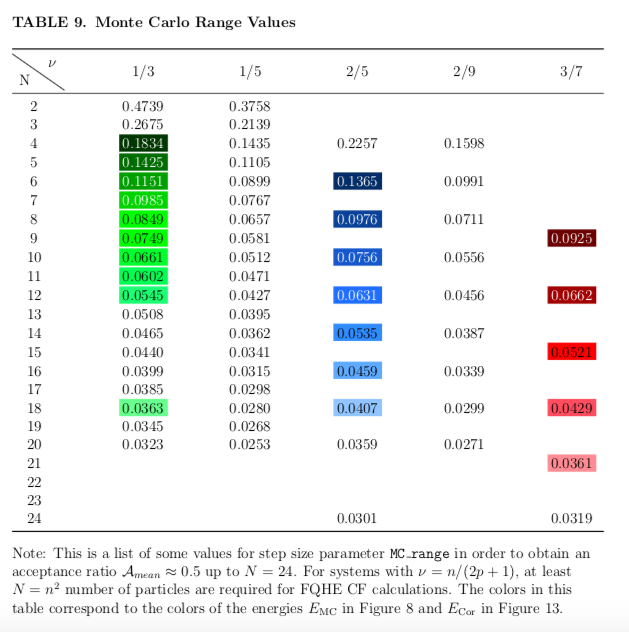

In [42]:
range_data = [[2, 0.4739], [3, 0.2675], [4, 0.1834], [5, 0.1425], [6, 0.1151], [7, 0.0985], [8, 0.0849], [9, 0.0749],
        [10, 0.0661], [11, 0.0602], [12, 0.0545], [13, 0.0508], [14, 0.0465], [15, 0.0440], [16, 0.0399],
        [17, 0.0385], [18, 0.0363], [19, 0.0345], [20, 0.0323]] 
  
dfRange = pd.DataFrame(range_data, columns = ['N', 'RANGE']) 
   
dfRange.head()

,N,RANGE
0,2,0.4739
1,3,0.2675
2,4,0.1834
3,5,0.1425
4,6,0.1151


Let us define a function of $N$ that we can use to find the fitting parameters for <code>RANGE</code>($N$) and then plot it.

In [43]:
def rangeFunc(n, c1, c2, c3):
    """Return the RANGE value."""
    
    res = c1*n**c2 + c3
    
    return res

In [44]:
nVals = dfRange['N'].to_list()
rangeVals = dfRange['RANGE'].to_list()

p0 = 1.2119101, -1.41925782, 0.01814921
popt, pcov = curve_fit(rangeFunc, nVals, rangeVals, p0)

display( Latex(f'RANGE$(N)={popt[0]}N^{{{popt[1]}}}+{popt[2]}$') )

<IPython.core.display.Latex object>

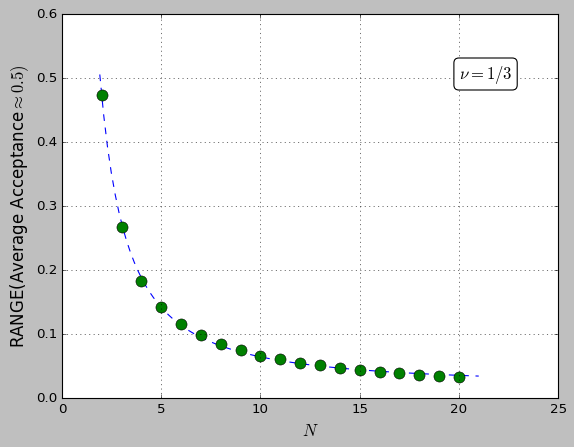

In [45]:
x = np.linspace(1.9, 21.0, num=100)
y = rangeFunc(x, popt[0], popt[1], popt[2])

plt.plot(x, y, '--')
plt.plot(nVals, rangeVals, 'o')
plt.xlabel(r'$N$')
plt.ylabel(r'RANGE(Average Acceptance$\approx0.5)$')

plt.text( 20., 0.5, r'$\nu=1/3$', size=15, bbox=dict(boxstyle="round", ec='black', fc='white') ) 

if print_plots_to_pdf:
    plt.savefig(plots_file_path + 'range_vs_n.pdf', format="pdf", bbox_inches="tight")
    
plt.show()

<a id='Bibliography'></a>
<hr style="height:2px;border-width:0;color:gray;background-color:gray">

<sup>1</sup> J. K. Jain and R. K. Kamilla, Int. J. Mod. Phys. B 11, 2621 (1997), doi: [10.1142/S0217979297001301](https://doi.org/10.1142/S0217979297001301)

<sup>2</sup> K. Park, V. Melik-Alaverdian, N. E. Bonesteel, and J. K. Jain, Phys. Rev. B **58**, R10167(R) (1998), doi: [10.1103/PhysRevB.58.R10167](https://doi.org/10.1103/PhysRevB.58.R10167)

<sup>3</sup> R. E. Wooten, PhD thesis (University of Tennessee, 2013).

<sup>4</sup> M. Arciniaga and M. R. Peterson, Phys. Rev. B **94**, 035105 (2016), doi: [10.1103/PhysRevB.94.035105](https://doi.org/10.1103/PhysRevB.94.035105)

<sup>5</sup> J. K. Jain, *Composite Fermions* (Cambridge University Press, 2007).

<sup>6</sup> Lee, Seung-Yeop, Vito W. Scarola, and J. K. Jain. "Stripe formation in the fractional quantum Hall regime." Phys. Rev. Let. **87**, 25 (2001), doi: &nbsp;&nbsp;&nbsp;[10.1103/PhysRevLett.87.256803](https://doi.org/10.1103/PhysRevLett.87.256803)

<sup>7</sup> U. Hernandez, MS thesis (California State University, Long Beach, 2019).